In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


%matplotlib inline

# 1. Motivating column subset selection

### Implement a preliminary column subset selection algorithm

In [2]:
from scipy.linalg import qr
def columnsubsetselect(A, k):
    u,s,vh = np.linalg.svd(A, full_matrices = False)
    
    _,_,p = qr(vh[:k,:], pivoting = True, mode = 'economic')
    p = p[:k]
    
    return A[:,p], p

### Construct matrix A from Sorensen and Embree paper

In [3]:
n = 300
A = np.zeros((2,n), dtype = 'd')
mat =  np.array([[-1.,4.],[1.,4.]])/np.sqrt(2)
for i in range(n):
    if i < n/2:
        A[0,i] = np.random.randn(1)
        A[1,i] = 4*np.random.randn(1)
    else: 
        A[:,i] = np.dot(mat,np.random.randn(2))

### Compare principal directions versus selected columns

Text(0.5, 1.0, 'Representative columns')

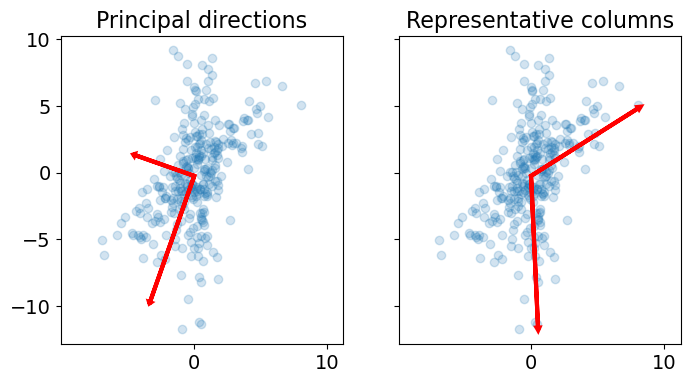

In [4]:
mu = np.mean(A,1)
u,s,vh = np.linalg.svd(A - np.tile(mu[:,np.newaxis],(1,n)), full_matrices = False)


f, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (8,4))
# plot data along with the principal directions
ax1.scatter(A[0,:], A[1, :], alpha=0.2)
for i in range(s.size):
    v =  0.15*u[:,i]* s[i]
    ax1.arrow(mu[0], mu[1], v[0], v[1], linewidth = 3.0, head_width=0.15, head_length=0.1, fc='r', ec='r')
ax1.axis('equal');
ax1.set_title('Principal directions', fontsize = 16)
# plot the selected columns
ax2.scatter(A[0,:], A[1, :], alpha=0.2)
c,p = columnsubsetselect(A,2)
for i in range(s.size):
    v = c[:,i] 
    ax2.arrow(mu[0], mu[1], v[0], v[1], linewidth = 3.0, head_width=0.2, head_length=0.2, fc='r', ec='r')
ax2.axis('equal');
ax2.set_title('Representative columns', fontsize = 16)

# 2. Eigenfaces

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print("Target names", faces.target_names)
print("Size of images ", faces.images.shape)
print("Shape of data", faces.data.shape)

Target names ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
Size of images  (1348, 62, 47)
Shape of data (1348, 2914)


### Plot representative faces from this dataset

['Tony Blair' 'George W Bush' 'George W Bush' 'George W Bush'
 'George W Bush' 'Ariel Sharon' 'George W Bush' 'Tony Blair'
 'George W Bush' 'George W Bush' 'Tony Blair' 'Colin Powell'
 'George W Bush' 'Junichiro Koizumi' 'George W Bush' 'Hugo Chavez'
 'Ariel Sharon' 'Ariel Sharon' 'Donald Rumsfeld' 'Donald Rumsfeld']


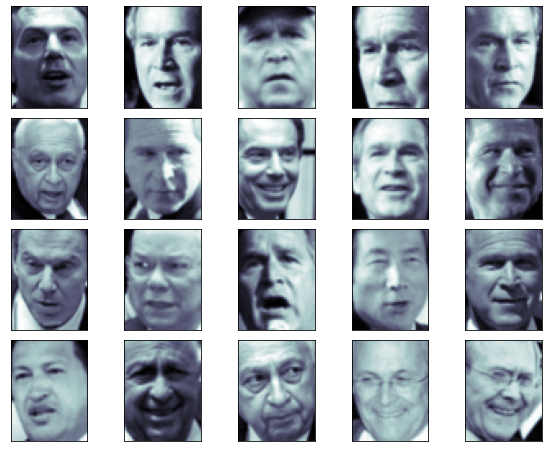

In [18]:
from scipy.sparse.linalg import svds, aslinearoperator

def columnsubsetselect(A, k):
    """
        More efficient than previous version for large-scale problems
    """
    u,s,vh = svds(aslinearoperator(A), k = k)
    _,_,p = qr(vh[:k,:], pivoting = True, mode = 'economic')
    p = p[:k]
    
    return A[:,p], p


c,p = columnsubsetselect(faces.data.T, 20)
fig, axes = plt.subplots(4, 5, figsize=(10, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(c[:,i].reshape(62, 47), cmap = 'bone')
    
print(faces.target_names[faces.target[p]])

In [19]:
for i, name in enumerate(faces.target_names):
    print(name + '\'s face appears '+  str(np.argwhere(faces.target ==i).size) + ' times')

Ariel Sharon's face appears 77 times
Colin Powell's face appears 236 times
Donald Rumsfeld's face appears 121 times
George W Bush's face appears 530 times
Gerhard Schroeder's face appears 109 times
Hugo Chavez's face appears 71 times
Junichiro Koizumi's face appears 60 times
Tony Blair's face appears 144 times


### Compare this with eigenfaces

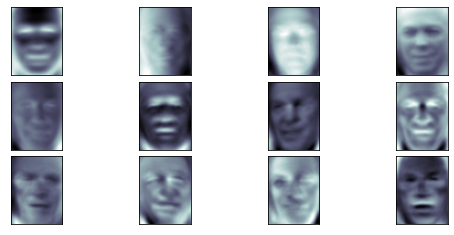

In [20]:
 u,s,vh = np.linalg.svd(faces.data.T, full_matrices=False)
fig, axes = plt.subplots(3, 4, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(u[:,i].reshape(62, 47), cmap='bone')

# 3. Algorithms 

Shape of the matrix is  (768, 1024)


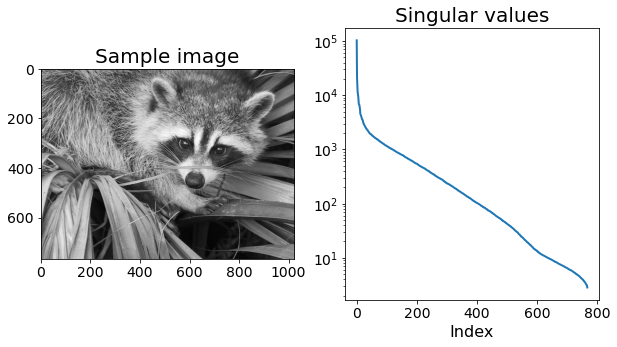

In [21]:
from scipy.misc import face
A = face(gray = True)

print("Shape of the matrix is ", A.shape)
u,s,vh = np.linalg.svd(A, full_matrices = False)


#Plot the image alongside the singular values
f, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.imshow(A, cmap=plt.cm.gray)
ax1.set_title('Sample image', fontsize = 20)
ax2.semilogy(s, linewidth = 2.0)
ax2.set_xlabel('Index', fontsize = 16)
ax2.set_title('Singular values', fontsize = 20)
plt.show()

## Method 1: using pivoted QR factorization

In [22]:
from scipy.linalg import qr
def cur_id(A, k = 20):
    # Use Pivoted QR for speed
    _, _, p = qr(A, mode = 'economic', pivoting = True)
    
    #Extract first few columns
    C = A[:,p[:k]]
    
    #Efficient implementation of pseudoinverse
    q, r = qr(C, mode = 'economic')
    X = np.linalg.solve(r,np.dot(q.T,A))
    
    return C, X, p[:k]

### Reconstruction using the PQR method

In [23]:
C, X, p = cur_id(A, k = 30)

# To visualize Selected indices
I = 0.*A
I[:,p] = 1.

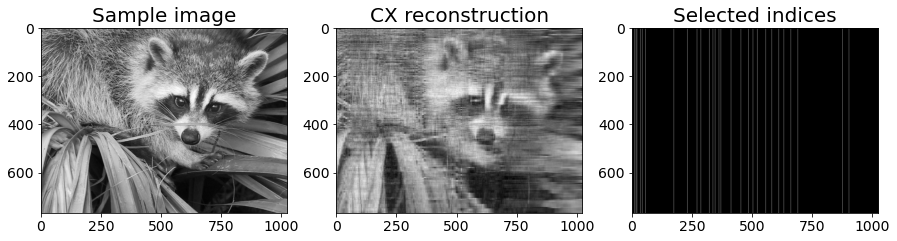

In [24]:
#Plot the reconstructed image
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,5))
ax1.imshow(A, cmap=plt.cm.gray)
ax1.set_title('Sample image', fontsize = 20)
ax2.imshow(np.dot(C,X), cmap=plt.cm.gray)
ax2.set_title('CX reconstruction', fontsize = 20)


ax3.imshow(I, cmap=plt.cm.gray)
ax3.set_title('Selected indices', fontsize = 20)
plt.show()

In [25]:
print("Selected indices", np.sort(p))

Selected indices [   0   10   16   20   34   42   55  173  229  269  285  320  335  344
  360  368  410  451  482  501  519  554  579  608  629  658  687  872
  899 1023]


### Compare the accuracy with SVD

Text(0.5, 1.0, 'Frobenius-norm ')

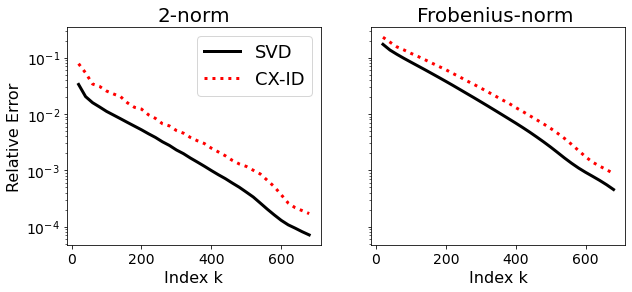

In [26]:
#Define the target ranks
ranks = range(20,700,20)

error  = np.zeros((len(ranks),4))
A2nrm  = np.linalg.norm(A, 2)
Afnrm  = np.linalg.norm(A, 'fro')


#Compute the partial errors and storage costs
for i, r in enumerate(ranks):
    C, X, p = cur_id(A, r)
    Ah = np.dot(C,X)
    
    #Spectral norm
    error[i,0] = s[r]/A2nrm
    error[i,1] = np.linalg.norm(A-Ah,2)/A2nrm

    # Frobenius norm
    error[i,2] = np.sqrt(np.sum(s[r:]**2.))/Afnrm
    error[i,3] = np.linalg.norm(A-Ah)/Afnrm
    
# plot the errors
f, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4))
ax1.semilogy(ranks,error[:,0],  'k-', ranks,error[:,1], 'r:', linewidth = 3.0)
ax1.set_xlabel('Index k', fontsize = 16)
ax1.set_ylabel('Relative Error', fontsize = 16)
ax1.legend({'SVD','CX-ID'}, fontsize = 18)
ax1.set_title('2-norm', fontsize = 20)

ax2.semilogy(ranks,error[:,2],  'k-', ranks,error[:,3], 'r:', linewidth = 3.0)
ax2.set_xlabel('Index k', fontsize = 16)
ax2.set_title('Frobenius-norm ', fontsize = 20)

## Method 2 : SVD + subset selection

In [27]:
def cur_svd(A, vk, k = 20):
    _,_,p = qr(vh[:k,:], pivoting = True, mode = 'economic')
    p = p[:k]
    C = A[:,p]
    
    #Efficient implementation of pseudoinverse
    q, r = qr(C, mode = 'economic')
    X = np.linalg.solve(r,np.dot(q.T,A))
    
    return C, X, p

Text(0.5, 1.0, 'Frobenius-norm ')

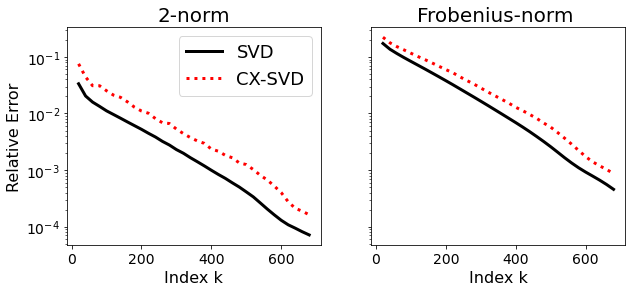

In [28]:
#Define the target ranks
ranks = range(20,700,20)

error  = np.zeros((len(ranks),4))
A2nrm  = np.linalg.norm(A, 2)
Afnrm  = np.linalg.norm(A, 'fro')

u,s,vh = np.linalg.svd(A, full_matrices = False)

#Compute the partial errors and storage costs
for i, r in enumerate(ranks):
    C, X, p = cur_svd(A, vh, r)
    Ah = np.dot(C,X)
    
    #Spectral norm
    error[i,0] = s[r]/A2nrm
    error[i,1] = np.linalg.norm(A-Ah,2)/A2nrm

    # Frobenius norm
    error[i,2] = np.sqrt(np.sum(s[r:]**2.))/Afnrm
    error[i,3] = np.linalg.norm(A-Ah)/Afnrm
    
# plot the errors
f, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4))
ax1.semilogy(ranks,error[:,0],  'k-', ranks,error[:,1], 'r:', linewidth = 3.0)
ax1.set_xlabel('Index k', fontsize = 16)
ax1.set_ylabel('Relative Error', fontsize = 16)
ax1.legend({'SVD','CX-SVD'}, fontsize = 18)
ax1.set_title('2-norm', fontsize = 20)

ax2.semilogy(ranks,error[:,2],  'k-', ranks,error[:,3], 'r:', linewidth = 3.0)
ax2.set_xlabel('Index k', fontsize = 16)
ax2.set_title('Frobenius-norm ', fontsize = 20)

# 4. Column and Row subset selection

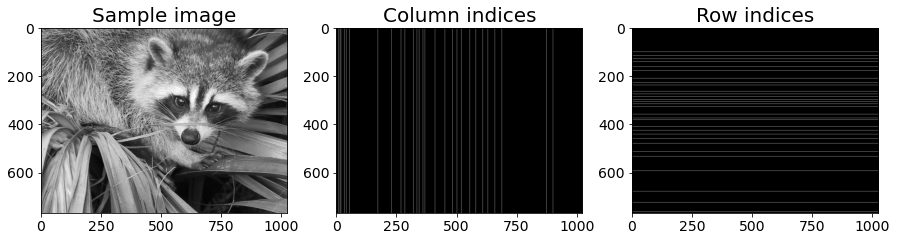

In [29]:
k = 30
_, _, p = qr(A, mode = 'economic', pivoting = True)
p = p[:k]
    
_, _, q = qr(A.T, mode = 'economic', pivoting = True)
q = q[:k]    

#Plot the reconstructed image
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,5))
ax1.imshow(A, cmap=plt.cm.gray)
ax1.set_title('Sample image', fontsize = 20)

Ip = 0*A; Ip[:,p] = 1.
ax2.imshow(Ip, cmap=plt.cm.gray)
ax2.set_title('Column indices', fontsize = 20)

Iq = 0*A; Iq[q,:] = 1.
ax3.imshow(Iq, cmap=plt.cm.gray)
ax3.set_title('Row indices', fontsize = 20)
plt.show()